In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

import torch
from torch import nn

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"default device set to {device}")

default device set to cuda


# Data cleaning
- Remove columns that won't be passed through the model
- Find and replace/remove missing data

In [4]:
train_dataset = pd.read_csv("/kaggle/input/titanic/train.csv")
train_dataset.sample(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
504,505,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,B79,S
114,115,0,3,"Attalah, Miss. Malake",female,17.0,0,0,2627,14.4583,NaN,C
852,853,0,3,"Boulos, Miss. Nourelain",female,9.0,1,1,2678,15.2458,NaN,C
589,590,0,3,"Murdlin, Mr. Joseph",male,NaN,0,0,A./5. 3235,8.0500,NaN,S
708,709,1,1,"Cleaver, Miss. Alice",female,22.0,0,0,113781,151.5500,NaN,S


In [5]:
test_dataset = pd.read_csv("/kaggle/input/titanic/test.csv")
test_dataset

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [6]:
train_dataset.drop(columns=["Name", "Cabin", "Ticket", "PassengerId"], inplace=True)

In [7]:
train_dataset.sample(n=4)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
401,0,3,male,26.0,0,0,8.0500,S
740,1,1,male,NaN,0,0,30.0000,S
680,0,3,female,NaN,0,0,8.1375,Q
697,1,3,female,NaN,0,0,7.7333,Q


In [8]:
def clean_data(data, column, total_null):
    if total_null <= len(data) * (5/100): # less than 5%
        data.dropna(subset=[column], inplace=True)
        
def check_data(data, clean: bool):
    for column in data.columns:
        if data[column].isnull().any():
            total_null_entries = data[column].isnull().sum()
            null_percent = total_null_entries / len(data) * 100
            print(f"null value found in the column {column}; totaling {total_null_entries} null entries; {null_percent}%")
            
            if clean:
                clean_data(data=data, column=column, total_null=total_null_entries)
        if column not in ["Age", "Fare", "PassengerId"]:
            print(f"{column} unique values --> {data[column].unique()}")

In [9]:
check_data(data=train_dataset, clean=True)
check_data(data=train_dataset, clean=False)

Survived unique values --> [0 1]
Pclass unique values --> [3 1 2]
Sex unique values --> ['male' 'female']
null value found in the column Age; totaling 177 null entries; 19.865319865319865%
SibSp unique values --> [1 0 3 4 2 5 8]
Parch unique values --> [0 1 2 5 3 4 6]
null value found in the column Embarked; totaling 2 null entries; 0.22446689113355783%
Embarked unique values --> ['S' 'C' 'Q']
Survived unique values --> [0 1]
Pclass unique values --> [3 1 2]
Sex unique values --> ['male' 'female']
null value found in the column Age; totaling 177 null entries; 19.910011248593925%
SibSp unique values --> [1 0 3 4 2 5 8]
Parch unique values --> [0 1 2 5 3 4 6]
Embarked unique values --> ['S' 'C' 'Q']


In [10]:
median_age = train_dataset["Age"].median()
train_dataset.fillna({"Age": median_age}, inplace=True)

In [11]:
train_dataset.sample(n=5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
55,1,1,male,28.0,0,0,35.5000,S
618,1,2,female,4.0,2,1,39.0000,S
541,0,3,female,9.0,4,2,31.2750,S
473,1,2,female,23.0,0,0,13.7917,C
826,0,3,male,28.0,0,0,56.4958,S


# Data visualization, survival comparison
- Visualize the relation within the data

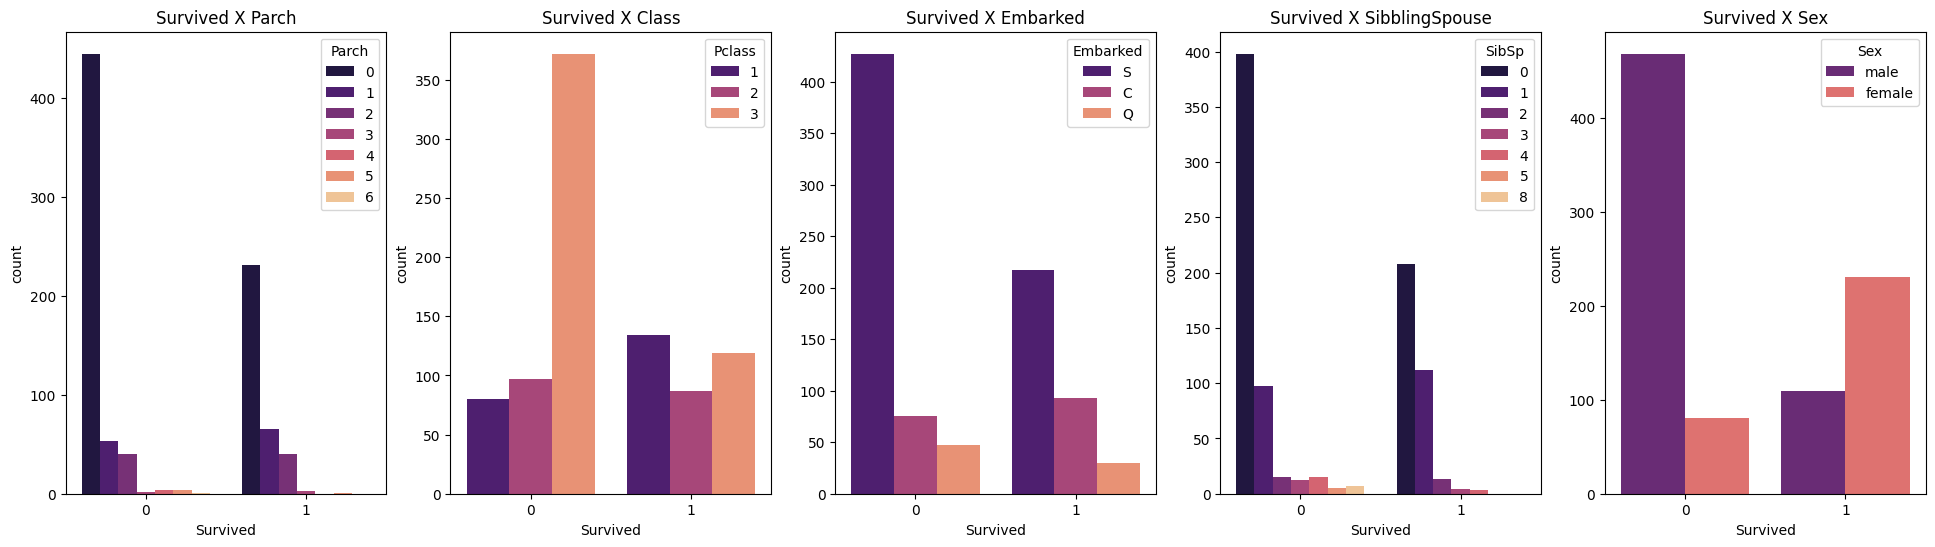

In [12]:
def plot_data(data):
    fig, axis = plt.subplots(1, 5, figsize=(24, 6))
    sns.countplot(data=data, x="Survived", hue="Parch", palette="magma", ax=axis[0])
    sns.countplot(data=data, x="Survived", hue="Pclass", palette="magma", ax=axis[1])
    sns.countplot(data=data, x="Survived", hue="Embarked", palette="magma", ax=axis[2])
    sns.countplot(data=data, x="Survived", hue="SibSp", palette="magma", ax=axis[3])
    sns.countplot(data=data, x="Survived", hue="Sex", palette="magma", ax=axis[4])
    
    axis[0].set_title("Survived X Parch")
    axis[1].set_title("Survived X Class")
    axis[2].set_title("Survived X Embarked")
    axis[3].set_title("Survived X SibblingSpouse")
    axis[4].set_title("Survived X Sex")
    
    plt.show()
plot_data(data=train_dataset)

# Mapping classes to numbers

In [13]:
sex_mapping = {k: v for v, k in enumerate(train_dataset["Sex"].unique())}
embarked_mapping = {k: v for v, k in enumerate(train_dataset["Embarked"].unique())}

train_dataset["Sex"] = train_dataset["Sex"].map(sex_mapping)
train_dataset["Embarked"] = train_dataset["Embarked"].map(embarked_mapping)
train_dataset.sample(n=5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
91,0,3,0,20.0,0,0,7.8542,0
241,1,3,1,28.0,1,0,15.5000,2
272,1,2,1,41.0,0,1,19.5000,0
36,1,3,0,28.0,0,0,7.2292,1
780,1,3,1,13.0,0,0,7.2292,1


# Get batch function

In [14]:
def get_batch(data, batch_size):
    batch = data.sample(n=batch_size)
    batch_labels = batch["Survived"].to_numpy()
    batch_inputs = batch.drop(columns=["Survived"]).to_numpy()
    
    batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
    batch_labels = torch.tensor(batch_labels, dtype=torch.long)
    
    return (batch_inputs, batch_labels)

get_batch(data=train_dataset, batch_size=4)

(tensor([[ 2.0000,  1.0000, 34.0000,  0.0000,  1.0000, 23.0000,  0.0000],
         [ 3.0000,  1.0000, 28.0000,  1.0000,  0.0000, 15.5000,  2.0000],
         [ 3.0000,  1.0000, 14.0000,  0.0000,  0.0000,  7.8542,  0.0000],
         [ 2.0000,  0.0000, 42.0000,  0.0000,  0.0000, 13.0000,  0.0000]],
        device='cuda:0'),
 tensor([1, 1, 0, 1], device='cuda:0'))

In [15]:
class MLP(nn.Module):
    def __init__(self, n_inputs, n_classes, hidden_units_array, n_layers, dropout):
        super(MLP, self).__init__()
        layers = []
        prev_hidden_units = n_inputs
        
        for _ in range(n_layers):
            for hidden_units in hidden_units_array:
                layers.append(nn.Linear(in_features=prev_hidden_units, out_features=hidden_units))
                #layers.append(nn.BatchNorm1d(hidden_units))
                layers.append(nn.LayerNorm(hidden_units))
                layers.append(nn.LeakyReLU())
                layers.append(nn.Dropout(dropout))
                print(f"from {prev_hidden_units} to {hidden_units}")
                prev_hidden_units = hidden_units
            #layers.append(nn.LayerNorm(hidden_units_array[-1]))
        #layers.append(nn.LayerNorm(hidden_units_array[-1]))
        layers.append(nn.Linear(in_features=hidden_units_array[-1], out_features=n_classes))
        
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #return self.network(x) # (B, n_classes)
        x = self.network(x)
        return x

In [16]:
n_inputs = len(train_dataset.drop(columns=["Survived"]).columns)
n_classes = 1 # Either dead of alive; Binary Cross Entropy should suffice
#hidden_units_array = [8*8, 8*8*8, 8*8*8*8, 8*8*8*8]
hidden_units_array = [8*8*8, 8*8*8, 8*8*8, 8*8*8]
n_layers = 4
dropout = 0.25
model = MLP(n_inputs=n_inputs, n_classes=n_classes, hidden_units_array=hidden_units_array, n_layers=n_layers, dropout=dropout)

from 7 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512


In [17]:
test_loss_fn = nn.BCEWithLogitsLoss()
model.eval()
with torch.inference_mode():
    batch_inputs, batch_labels = get_batch(data=train_dataset, batch_size=32)
    logits = model(batch_inputs) # (B, n_classes); labels are (B,)
    loss = test_loss_fn(logits.view(-1), batch_labels.to(torch.float32)) # For BCEWithLogitsLoss, labels must be in float32 format; for CrossEntropyLoss use torch.long instead
    print(loss)

tensor(0.7164, device='cuda:0')


In [18]:
def train_model(model, data, batch_size, loss_fn, optimizer, epochs):
    model.train()

    #writer = SummaryWriter()
    #writer.add_text('Model Architecture', str(model))

    for epoch in tqdm(range(epochs)):
        batch_inputs, batch_labels = get_batch(data=train_dataset, batch_size=batch_size)
        logits = model(batch_inputs) # (B, n_classes)
        loss = loss_fn(logits.view(-1), batch_labels.to(torch.float32))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #scheduler.step()

        #writer.add_scalar("Training Loss", loss.item(), epoch)

        
        if (epoch+1) % 500 == 0:
            print(f"loss for epoch {epoch+1} --> {loss}")
            #print(batch_inputs)
            #print(logits)
    #writer.close()

In [19]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-4)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.05)
loss_fn = nn.BCEWithLogitsLoss()

epochs = 50000
train_model(model=model, data=train_dataset, batch_size=256, loss_fn=loss_fn, optimizer=optimizer, epochs=epochs)

  1%|          | 512/50000 [00:06<10:24, 79.23it/s]

loss for epoch 500 --> 0.5964613556861877


  2%|▏         | 1008/50000 [00:12<10:06, 80.79it/s]

loss for epoch 1000 --> 0.48799675703048706


  3%|▎         | 1512/50000 [00:19<10:07, 79.86it/s]

loss for epoch 1500 --> 0.47143200039863586


  4%|▍         | 2010/50000 [00:25<09:58, 80.16it/s]

loss for epoch 2000 --> 0.4731435775756836


  5%|▌         | 2515/50000 [00:32<10:01, 78.94it/s]

loss for epoch 2500 --> 0.4273771643638611


  6%|▌         | 3014/50000 [00:38<09:55, 78.94it/s]

loss for epoch 3000 --> 0.4740360975265503


  7%|▋         | 3509/50000 [00:44<09:37, 80.51it/s]

loss for epoch 3500 --> 0.41508036851882935


  8%|▊         | 4011/50000 [00:51<09:42, 78.99it/s]

loss for epoch 4000 --> 0.44857174158096313


  9%|▉         | 4510/50000 [00:57<09:31, 79.55it/s]

loss for epoch 4500 --> 0.4000456631183624


 10%|█         | 5011/50000 [01:03<09:41, 77.37it/s]

loss for epoch 5000 --> 0.42348504066467285


 11%|█         | 5508/50000 [01:10<09:07, 81.20it/s]

loss for epoch 5500 --> 0.4642329812049866


 12%|█▏        | 6009/50000 [01:16<09:32, 76.83it/s]

loss for epoch 6000 --> 0.36869773268699646


 13%|█▎        | 6510/50000 [01:22<09:10, 79.07it/s]

loss for epoch 6500 --> 0.42418596148490906


 14%|█▍        | 7013/50000 [01:29<08:59, 79.61it/s]

loss for epoch 7000 --> 0.35383474826812744


 15%|█▌        | 7511/50000 [01:35<08:57, 79.09it/s]

loss for epoch 7500 --> 0.3812240958213806


 16%|█▌        | 8009/50000 [01:41<08:41, 80.54it/s]

loss for epoch 8000 --> 0.41986531019210815


 17%|█▋        | 8513/50000 [01:47<08:46, 78.75it/s]

loss for epoch 8500 --> 0.4621899724006653


 18%|█▊        | 9011/50000 [01:54<08:37, 79.24it/s]

loss for epoch 9000 --> 0.4164177179336548


 19%|█▉        | 9515/50000 [02:00<08:32, 78.97it/s]

loss for epoch 9500 --> 0.381691575050354


 20%|██        | 10013/50000 [02:07<08:29, 78.56it/s]

loss for epoch 10000 --> 0.35081619024276733


 21%|██        | 10512/50000 [02:13<08:23, 78.35it/s]

loss for epoch 10500 --> 0.3692455291748047


 22%|██▏       | 11010/50000 [02:20<08:23, 77.38it/s]

loss for epoch 11000 --> 0.3588925004005432


 23%|██▎       | 11515/50000 [02:26<08:23, 76.41it/s]

loss for epoch 11500 --> 0.3409411311149597


 24%|██▍       | 12011/50000 [02:33<07:58, 79.36it/s]

loss for epoch 12000 --> 0.3990427553653717


 25%|██▌       | 12512/50000 [02:39<07:58, 78.35it/s]

loss for epoch 12500 --> 0.3560618758201599


 26%|██▌       | 13008/50000 [02:45<07:53, 78.11it/s]

loss for epoch 13000 --> 0.3463370203971863


 27%|██▋       | 13515/50000 [02:52<07:36, 79.88it/s]

loss for epoch 13500 --> 0.3622052073478699


 28%|██▊       | 14011/50000 [02:58<07:41, 78.00it/s]

loss for epoch 14000 --> 0.37089425325393677


 29%|██▉       | 14513/50000 [03:05<07:23, 80.07it/s]

loss for epoch 14500 --> 0.28315824270248413


 30%|███       | 15016/50000 [03:11<07:17, 79.94it/s]

loss for epoch 15000 --> 0.3937946557998657


 31%|███       | 15511/50000 [03:17<07:09, 80.31it/s]

loss for epoch 15500 --> 0.32191377878189087


 32%|███▏      | 16016/50000 [03:23<07:06, 79.64it/s]

loss for epoch 16000 --> 0.37202125787734985


 33%|███▎      | 16515/50000 [03:30<07:04, 78.97it/s]

loss for epoch 16500 --> 0.29860398173332214


 34%|███▍      | 17014/50000 [03:36<07:04, 77.75it/s]

loss for epoch 17000 --> 0.3318324685096741


 35%|███▌      | 17511/50000 [03:43<06:45, 80.13it/s]

loss for epoch 17500 --> 0.3610391318798065


 36%|███▌      | 18012/50000 [03:49<06:35, 80.82it/s]

loss for epoch 18000 --> 0.31361332535743713


 37%|███▋      | 18509/50000 [03:55<06:32, 80.27it/s]

loss for epoch 18500 --> 0.291157066822052


 38%|███▊      | 19016/50000 [04:02<06:28, 79.85it/s]

loss for epoch 19000 --> 0.3562510907649994


 39%|███▉      | 19508/50000 [04:08<06:22, 79.71it/s]

loss for epoch 19500 --> 0.33754557371139526


 40%|████      | 20007/50000 [04:14<06:13, 80.32it/s]

loss for epoch 20000 --> 0.30474287271499634


 41%|████      | 20513/50000 [04:20<06:06, 80.51it/s]

loss for epoch 20500 --> 0.3006485104560852


 42%|████▏     | 21012/50000 [04:27<06:04, 79.63it/s]

loss for epoch 21000 --> 0.34812358021736145


 43%|████▎     | 21510/50000 [04:33<06:21, 74.70it/s]

loss for epoch 21500 --> 0.3227112591266632


 44%|████▍     | 22011/50000 [04:39<06:00, 77.58it/s]

loss for epoch 22000 --> 0.30521705746650696


 45%|████▌     | 22513/50000 [04:46<05:54, 77.54it/s]

loss for epoch 22500 --> 0.26205748319625854


 46%|████▌     | 23015/50000 [04:52<05:46, 77.97it/s]

loss for epoch 23000 --> 0.28931209444999695


 47%|████▋     | 23511/50000 [04:59<05:36, 78.66it/s]

loss for epoch 23500 --> 0.3186829686164856


 48%|████▊     | 24009/50000 [05:05<05:34, 77.75it/s]

loss for epoch 24000 --> 0.38783949613571167


 49%|████▉     | 24511/50000 [05:11<05:23, 78.88it/s]

loss for epoch 24500 --> 0.30028030276298523


 50%|█████     | 25012/50000 [05:18<05:20, 77.96it/s]

loss for epoch 25000 --> 0.2595749497413635


 51%|█████     | 25512/50000 [05:24<05:06, 79.80it/s]

loss for epoch 25500 --> 0.2616592347621918


 52%|█████▏    | 26006/50000 [05:31<05:54, 67.72it/s]

loss for epoch 26000 --> 0.23579175770282745


 53%|█████▎    | 26512/50000 [05:37<04:55, 79.37it/s]

loss for epoch 26500 --> 0.2657061517238617


 54%|█████▍    | 27014/50000 [05:44<05:03, 75.71it/s]

loss for epoch 27000 --> 0.23296794295310974


 55%|█████▌    | 27516/50000 [05:50<04:46, 78.61it/s]

loss for epoch 27500 --> 0.36504706740379333


 56%|█████▌    | 28008/50000 [05:56<04:39, 78.72it/s]

loss for epoch 28000 --> 0.26034653186798096


 57%|█████▋    | 28508/50000 [06:03<04:57, 72.21it/s]

loss for epoch 28500 --> 0.25797054171562195


 58%|█████▊    | 29011/50000 [06:09<04:22, 80.01it/s]

loss for epoch 29000 --> 0.27061253786087036


 59%|█████▉    | 29509/50000 [06:15<04:37, 73.82it/s]

loss for epoch 29500 --> 0.3024190366268158


 60%|██████    | 30011/50000 [06:22<04:23, 75.90it/s]

loss for epoch 30000 --> 0.26373130083084106


 61%|██████    | 30511/50000 [06:28<04:04, 79.61it/s]

loss for epoch 30500 --> 0.293998658657074


 62%|██████▏   | 31012/50000 [06:35<04:05, 77.41it/s]

loss for epoch 31000 --> 0.31099143624305725


 63%|██████▎   | 31513/50000 [06:41<03:50, 80.30it/s]

loss for epoch 31500 --> 0.25513365864753723


 64%|██████▍   | 32008/50000 [06:47<03:46, 79.51it/s]

loss for epoch 32000 --> 0.2805929183959961


 65%|██████▌   | 32512/50000 [06:53<03:39, 79.75it/s]

loss for epoch 32500 --> 0.30249613523483276


 66%|██████▌   | 33012/50000 [07:00<03:30, 80.54it/s]

loss for epoch 33000 --> 0.1875525712966919


 67%|██████▋   | 33514/50000 [07:06<03:51, 71.35it/s]

loss for epoch 33500 --> 0.3012000024318695


 68%|██████▊   | 34010/50000 [07:12<03:18, 80.45it/s]

loss for epoch 34000 --> 0.2738907039165497


 69%|██████▉   | 34512/50000 [07:19<03:10, 81.17it/s]

loss for epoch 34500 --> 0.2612338960170746


 70%|███████   | 35012/50000 [07:25<03:05, 80.83it/s]

loss for epoch 35000 --> 0.2042948305606842


 71%|███████   | 35514/50000 [07:31<02:59, 80.82it/s]

loss for epoch 35500 --> 0.2673605680465698


 72%|███████▏  | 36008/50000 [07:38<03:18, 70.37it/s]

loss for epoch 36000 --> 0.25838667154312134


 73%|███████▎  | 36510/50000 [07:44<02:50, 79.08it/s]

loss for epoch 36500 --> 0.26103174686431885


 74%|███████▍  | 37010/50000 [07:50<02:43, 79.34it/s]

loss for epoch 37000 --> 0.24567124247550964


 75%|███████▌  | 37509/50000 [07:57<02:37, 79.32it/s]

loss for epoch 37500 --> 0.24181988835334778


 76%|███████▌  | 38009/50000 [08:03<02:30, 79.58it/s]

loss for epoch 38000 --> 0.24906399846076965


 77%|███████▋  | 38513/50000 [08:09<02:29, 76.88it/s]

loss for epoch 38500 --> 0.20982050895690918


 78%|███████▊  | 39015/50000 [08:16<02:23, 76.44it/s]

loss for epoch 39000 --> 0.27641385793685913


 79%|███████▉  | 39512/50000 [08:22<02:12, 79.25it/s]

loss for epoch 39500 --> 0.25701916217803955


 80%|████████  | 40015/50000 [08:28<02:05, 79.72it/s]

loss for epoch 40000 --> 0.2203224152326584


 81%|████████  | 40514/50000 [08:35<01:57, 81.04it/s]

loss for epoch 40500 --> 0.2734355926513672


 82%|████████▏ | 41012/50000 [08:41<02:13, 67.28it/s]

loss for epoch 41000 --> 0.2193109095096588


 83%|████████▎ | 41511/50000 [08:47<01:44, 81.01it/s]

loss for epoch 41500 --> 0.2166740596294403


 84%|████████▍ | 42012/50000 [08:53<01:39, 80.42it/s]

loss for epoch 42000 --> 0.2909904420375824


 85%|████████▌ | 42508/50000 [09:00<01:33, 79.71it/s]

loss for epoch 42500 --> 0.2632981538772583


 86%|████████▌ | 43016/50000 [09:06<01:28, 79.36it/s]

loss for epoch 43000 --> 0.27546167373657227


 87%|████████▋ | 43508/50000 [09:12<01:28, 73.03it/s]

loss for epoch 43500 --> 0.2761370837688446


 88%|████████▊ | 44014/50000 [09:19<01:14, 79.86it/s]

loss for epoch 44000 --> 0.2697339653968811


 89%|████████▉ | 44513/50000 [09:25<01:09, 78.66it/s]

loss for epoch 44500 --> 0.2052796483039856


 90%|█████████ | 45016/50000 [09:31<01:02, 80.03it/s]

loss for epoch 45000 --> 0.2798031270503998


 91%|█████████ | 45515/50000 [09:38<00:56, 79.68it/s]

loss for epoch 45500 --> 0.2523086667060852


 92%|█████████▏| 46015/50000 [09:44<00:52, 75.37it/s]

loss for epoch 46000 --> 0.2537824511528015


 93%|█████████▎| 46515/50000 [09:50<00:43, 80.32it/s]

loss for epoch 46500 --> 0.23976296186447144


 94%|█████████▍| 47014/50000 [09:57<00:37, 79.43it/s]

loss for epoch 47000 --> 0.1867971271276474


 95%|█████████▌| 47508/50000 [10:03<00:31, 79.58it/s]

loss for epoch 47500 --> 0.2548079490661621


 96%|█████████▌| 48010/50000 [10:09<00:24, 80.22it/s]

loss for epoch 48000 --> 0.24469545483589172


 97%|█████████▋| 48510/50000 [10:16<00:21, 68.84it/s]

loss for epoch 48500 --> 0.2290773093700409


 98%|█████████▊| 49016/50000 [10:22<00:12, 79.93it/s]

loss for epoch 49000 --> 0.22499428689479828


 99%|█████████▉| 49511/50000 [10:28<00:06, 76.84it/s]

loss for epoch 49500 --> 0.2756706476211548


100%|██████████| 50000/50000 [10:35<00:00, 78.73it/s]

loss for epoch 50000 --> 0.20731136202812195


In [20]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.05)
loss_fn = nn.BCEWithLogitsLoss()

epochs = 10000
train_model(model=model, data=train_dataset, batch_size=256, loss_fn=loss_fn, optimizer=optimizer, epochs=epochs)

  5%|▌         | 514/10000 [00:06<02:02, 77.58it/s]

loss for epoch 500 --> 0.23674288392066956


 10%|█         | 1013/10000 [00:13<01:54, 78.74it/s]

loss for epoch 1000 --> 0.24446246027946472


 15%|█▌        | 1511/10000 [00:19<01:46, 79.35it/s]

loss for epoch 1500 --> 0.25813308358192444


 20%|██        | 2011/10000 [00:25<01:39, 80.15it/s]

loss for epoch 2000 --> 0.20686575770378113


 25%|██▌       | 2514/10000 [00:32<01:34, 79.31it/s]

loss for epoch 2500 --> 0.19284352660179138


 30%|███       | 3011/10000 [00:38<01:31, 76.20it/s]

loss for epoch 3000 --> 0.24203208088874817


 35%|███▌      | 3514/10000 [00:44<01:20, 80.49it/s]

loss for epoch 3500 --> 0.22178901731967926


 40%|████      | 4009/10000 [00:51<01:14, 80.15it/s]

loss for epoch 4000 --> 0.2251547873020172


 45%|████▌     | 4514/10000 [00:57<01:09, 79.45it/s]

loss for epoch 4500 --> 0.17997810244560242


 50%|█████     | 5008/10000 [01:03<01:03, 79.01it/s]

loss for epoch 5000 --> 0.19915089011192322


 55%|█████▌    | 5509/10000 [01:10<00:59, 75.26it/s]

loss for epoch 5500 --> 0.23449286818504333


 60%|██████    | 6012/10000 [01:16<00:50, 78.97it/s]

loss for epoch 6000 --> 0.19690066576004028


 65%|██████▌   | 6512/10000 [01:23<00:45, 76.76it/s]

loss for epoch 6500 --> 0.22382418811321259


 70%|███████   | 7008/10000 [01:29<00:38, 77.34it/s]

loss for epoch 7000 --> 0.2553333342075348


 75%|███████▌  | 7510/10000 [01:35<00:31, 79.57it/s]

loss for epoch 7500 --> 0.23250369727611542


 80%|████████  | 8013/10000 [01:42<00:24, 79.76it/s]

loss for epoch 8000 --> 0.2111835777759552


 85%|████████▌ | 8513/10000 [01:48<00:18, 78.45it/s]

loss for epoch 8500 --> 0.20578208565711975


 90%|█████████ | 9011/10000 [01:55<00:12, 78.38it/s]

loss for epoch 9000 --> 0.19438692927360535


 95%|█████████▌| 9515/10000 [02:01<00:06, 76.85it/s]

loss for epoch 9500 --> 0.22048011422157288


100%|██████████| 10000/10000 [02:07<00:00, 78.17it/s]

loss for epoch 10000 --> 0.1980825960636139


In [21]:
test_dataset = pd.read_csv("/kaggle/input/titanic/test.csv")
test_dataset.drop(columns=["Name", "Cabin", "Ticket"], inplace=True)
check_data(data=test_dataset, clean=False)
test_dataset.count()

Pclass unique values --> [3 2 1]
Sex unique values --> ['male' 'female']
null value found in the column Age; totaling 86 null entries; 20.574162679425836%
SibSp unique values --> [0 1 2 3 4 5 8]
Parch unique values --> [0 1 3 2 4 6 5 9]
null value found in the column Fare; totaling 1 null entries; 0.23923444976076555%
Embarked unique values --> ['Q' 'S' 'C']


PassengerId    418
Pclass         418
Sex            418
Age            332
SibSp          418
Parch          418
Fare           417
Embarked       418
dtype: int64

In [22]:
median_fare = test_dataset["Fare"].median()
test_dataset.fillna({"Fare": median_fare}, inplace=True)
check_data(data=test_dataset, clean=False)
test_dataset

Pclass unique values --> [3 2 1]
Sex unique values --> ['male' 'female']
null value found in the column Age; totaling 86 null entries; 20.574162679425836%
SibSp unique values --> [0 1 2 3 4 5 8]
Parch unique values --> [0 1 3 2 4 6 5 9]
Embarked unique values --> ['Q' 'S' 'C']


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...,...
413,1305,3,male,NaN,0,0,8.0500,S
414,1306,1,female,39.0,0,0,108.9000,C
415,1307,3,male,38.5,0,0,7.2500,S
416,1308,3,male,NaN,0,0,8.0500,S


In [23]:
median_age = train_dataset["Age"].median()
test_dataset.fillna({"Age": median_age}, inplace=True)

test_dataset["Sex"] = test_dataset["Sex"].map(sex_mapping)
test_dataset["Embarked"] = test_dataset["Embarked"].map(embarked_mapping)

check_data(data=test_dataset, clean=False)

Pclass unique values --> [3 2 1]
Sex unique values --> [0 1]
SibSp unique values --> [0 1 2 3 4 5 8]
Parch unique values --> [0 1 3 2 4 6 5 9]
Embarked unique values --> [2 0 1]


In [24]:
test_dataset.count()

PassengerId    418
Pclass         418
Sex            418
Age            418
SibSp          418
Parch          418
Fare           418
Embarked       418
dtype: int64

In [25]:
test_dataset.sample(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
348,1240,2,0,24.0,0,0,13.5,0
218,1110,1,1,50.0,1,1,211.5,1
382,1274,3,1,28.0,0,0,14.5,0
229,1121,2,0,36.0,0,0,13.0,0
172,1064,3,0,23.0,1,0,13.9,0


In [26]:
def model_inference(model, data):
    model.eval()
    outputs = {
        "PassengerId": [],
        "Survived": []
    }

    for i in range(len(data)):
        Pid = data["PassengerId"].iloc[i]

        inputs = torch.tensor(data.drop(columns="PassengerId").iloc[i].to_numpy(), dtype=torch.float32)
        with torch.inference_mode():
            logits = model(inputs) # shape of 1
            probs = torch.sigmoid(logits)
            pred = (probs > 0.5).int()
            outputs["PassengerId"].append(Pid)
            outputs["Survived"].append(pred.item())
    return outputs


In [27]:
df = pd.DataFrame(model_inference(model=model, data=test_dataset))
df.to_csv("/kaggle/working/submission.csv", index=False)
